# importing and creating neccessary functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
import pandas as pd
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML

%matplotlib inline

In [4]:
@jit(nopython=True)
def generate_v_OU(nr_trials=1000, noise_sd=1, tmax=5, dt=0.01, start=2, end=5):
    
    start = int(start/dt)
    end = int(end/dt)
    
    v = np.zeros(shape=(2, nr_trials, 500))
    v[0, :, start:end] = 1*dt
    
    
    for i in range(500):
        v[0, :, i] += np.random.normal(0, noise_sd/np.sqrt(2), nr_trials)*np.sqrt(dt)
        v[1, :, i] += np.random.normal(0, noise_sd/np.sqrt(2), nr_trials)*np.sqrt(dt)
    
    return v
    
    
    
@jit(nopython=True)   
def get_OU_traces(v, ll, dc, z, noise_sd=1, pre_generated=False, nr_trials=1000, tmax=5.0, dt=0.01):
    
    
    x1 = np.zeros((nr_trials, int(tmax/dt)))
    x2 = np.zeros((nr_trials, int(tmax/dt)))
    x1[:,:] = np.NaN
    x2[:,:] = np.NaN
    x1[:,0] = z[0]
    x2[:,0] = z[1]
    for i in range((int(tmax/dt))-1):
        if pre_generated:
            x1[:,i+1] = x1[:,i] + v[0][:,i] + (dc[0] - (ll[0]*x1[:,i]))*dt
            x2[:,i+1] = x2[:,i] + v[1][:,i] + (dc[1] - (ll[1]*x2[:,i]))*dt
        else:
            x1[:,i+1] = x1[:,i] + ((v[0] + dc[0] - (ll[0]*x1[:,i])) * dt) +(np.random.normal(0,noise_sd/np.sqrt(2),nr_trials)*np.sqrt(dt))
            x2[:,i+1] = x2[:,i] + ((v[1] + dc[1] - (ll[1]*x2[:,i])) * dt) + (np.random.normal(0,noise_sd/np.sqrt(2),nr_trials)*np.sqrt(dt))
    return x1-x2

@jit(nopython=True)
def apply_bounds_diff_trace(x, b1, b0):
    rt = np.zeros(x.shape[0])
    rt[:] = np.nan
    response = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i,j] >= b1[j]:
                rt[i] = j
                response[i] = 1
                break
    return rt, response

In [5]:
def sim(ll1, ll2,trials):
    
    dt = 0.01
    
    start = 3.0
    end = 5.0
    

#     v = generate_v_OU(start=start, end=end)
    ll = np.array([ll1, ll2])
    dc = np.array([0.0, 0.0])
    z = np.array([0.0, 0.0])

    
    x = get_OU_traces(v=v, ll=ll, dc=dc, z=z, pre_generated=True, nr_trials=trials, tmax = 5.0, dt=0.01)
    b1 = np.ones(x.shape[1])
    b0 = np.ones(x.shape[1]) * -1
    rt, response = apply_bounds_diff_trace(x, b1, b0)
    df = pd.DataFrame()
    df['rt'] = rt * dt
    df['response'] = response
    
    df['false alarm'] = (df['response'] == 1) & (df['rt'] < start)
    df['hit'] = (df['response'] == 1) & (df['rt'] >= start)
    df['miss'] = (~df['hit']) & (~df['false alarm'])
    #df['rt quantile'] = pd.qcut(df['rt'], 5, labels=False)
    
    return (x, df, df['false alarm'].mean(), df['hit'].mean(), df['miss'].mean(), df['rt'].mean())

In [10]:
@jit(nopython=True)
def meme():
    l = np.ones(5)
    print(l[10])
    
meme()

0.0


# Analyzing the Simulation

In [12]:
import time

start = time.time()

n = 100
params = np.linspace(0, 10, n)
far = np.zeros(n)
hit = np.zeros(n)
miss = np.zeros(n)
rt = np.zeros(n)
ll = np.zeros(n)
trials = 200
v = generate_v_OU(nr_trials = trials, start=3, end=5)
traces = np.zeros((n, trials, 500))
frames = []




for i in range(len(params)):
    x, df, f, h, m, r = sim(params[i], params[i],trials)
    far[i] = f
    hit[i] = h 
    miss[i] = m
    rt[i] = r
    ll[i] = params[i]
    traces[i] = x
    frames.append(df)

    
# print(fl)
# print(hl)
print(time.time() - start)

1.5360023975372314


<Figure size 432x288 with 0 Axes>

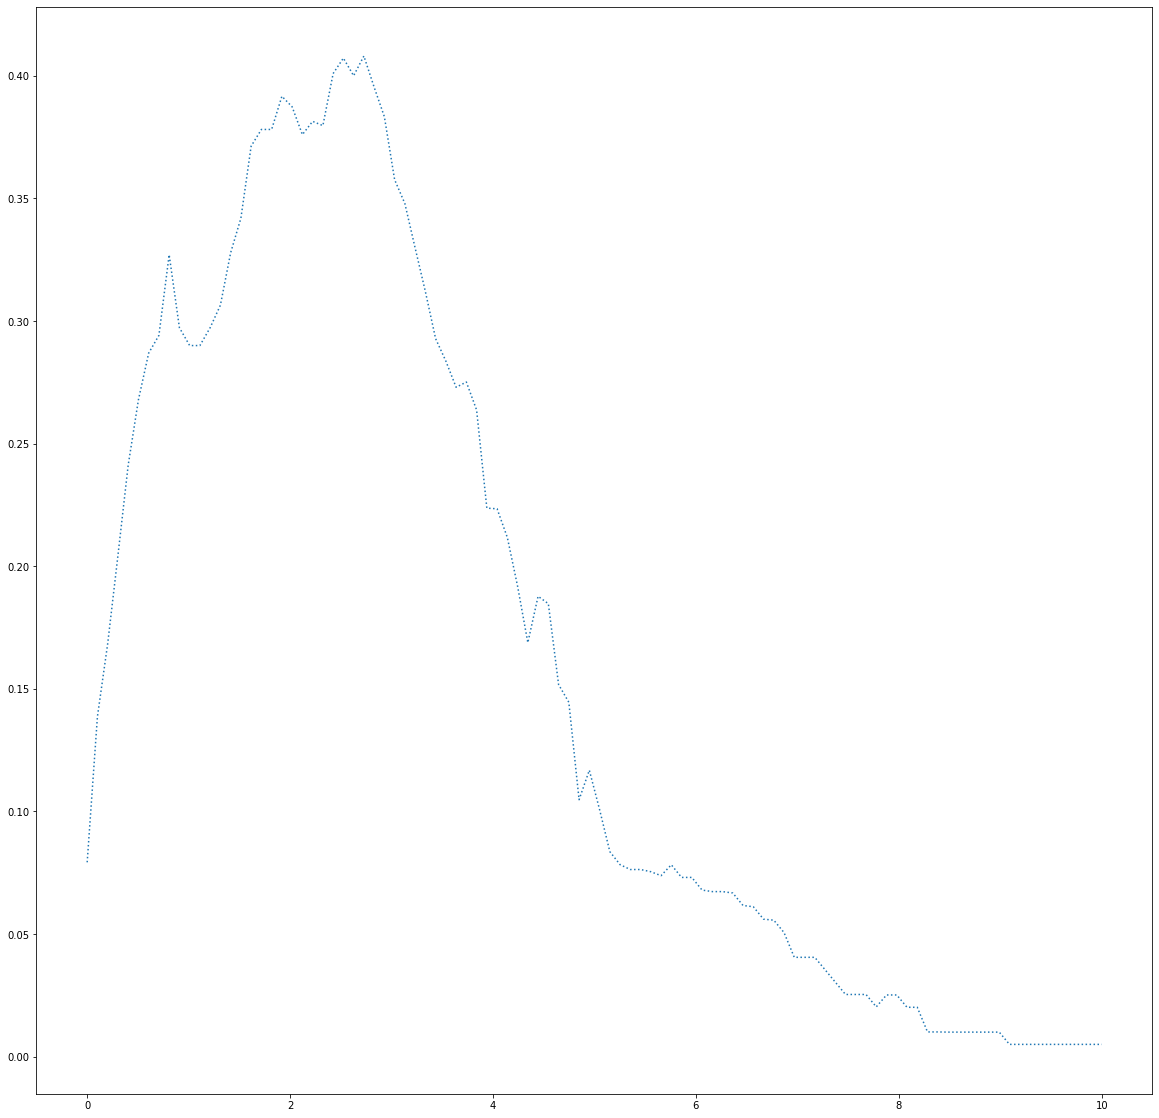

In [13]:
plt.figure()
hr = hit / (hit + miss)
plt.subplots(figsize = (20, 20))

plt.plot(params, hr-far, ':')

In [14]:
frames[9].head()

,rt,response,false alarm,hit,miss
0,4.87,1.0,False,True,False
1,NaN,0.0,False,False,True
2,3.06,1.0,False,True,False
3,2.48,1.0,True,False,False
4,1.60,1.0,True,False,False


# Grid search with two parameters

In [16]:
import time

start = time.time()

n = 50

far = np.zeros((n, n))
hit = np.zeros((n, n))
miss = np.zeros((n, n))
rt = np.zeros((n, n))

ll1 = np.linspace(-5, 5, n)
ll2 = np.linspace(-5, 5, n)


trials = 200
v = generate_v_OU(nr_trials = trials, start=2, end=5)
traces = np.zeros((n, trials, 500))
params = np.zeros(shape = (len(ll1), len(ll2)))
    
    
for i in range(len(ll1)):
    for j in range(len(ll2)):
        _, _, f, h, m, r = sim(ll1[i], ll2[j], trials)
        far[i, j] = f
        hit[i, j] = h
        miss[i, j] = m
        
    
    
    
# print(fl)
# print(hl)
print(time.time() - start)

35.2986044883728


In [17]:
far

array([[0.55 , 0.555, 0.575, ..., 0.545, 0.545, 0.545],
       [0.585, 0.555, 0.565, ..., 0.555, 0.555, 0.555],
       [0.62 , 0.595, 0.555, ..., 0.55 , 0.55 , 0.55 ],
       ...,
       [0.535, 0.53 , 0.53 , ..., 0.15 , 0.14 , 0.13 ],
       [0.535, 0.53 , 0.53 , ..., 0.14 , 0.13 , 0.13 ],
       [0.535, 0.53 , 0.53 , ..., 0.14 , 0.135, 0.125]])

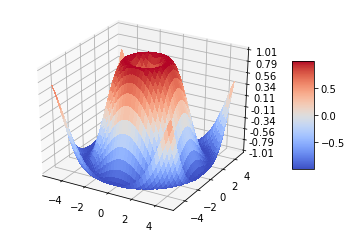

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

(29, 48)
ll1: 0.9183673469387754
ll2: 4.795918367346939
max: 0.3368292682926829


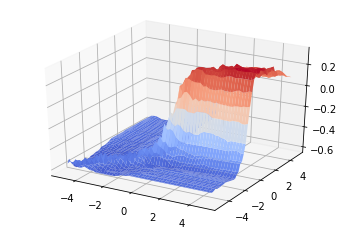

In [22]:
%matplotlib inline

x, y = np.meshgrid(ll1, ll2)
hr = hit
fig = plt.figure()
ax = fig.gca(projection='3d')
sub = (hit / (hit + miss)) - far
surf = ax.plot_surface(x, y, sub, cmap = cm.coolwarm)

ind = np.unravel_index(np.argmax(sub), shape=sub.shape)
print(ind)
print(f'll1: {ll1[ind[0]]}')
print(f'll2: {ll2[ind[1]]}')
print(f'max: {np.amax(sub)}')


# Searching for the optimal leak over time gridsearch

In [51]:
def sim(ll1, ll2,trials, start, end):
    
    dt = 0.01
    
    

#     v = generate_v_OU(start=start, end=end)
    ll = np.array([ll1, ll2])
    dc = np.array([0.0, 0.0])
    z = np.array([0.0, 0.0])

    
    x = get_OU_traces(v=v, ll=ll, dc=dc, z=z, pre_generated=True, nr_trials=trials, tmax = 5.0, dt=0.01)
    b1 = np.ones(x.shape[1])
    b0 = np.ones(x.shape[1]) * -1
    rt, response = apply_bounds_diff_trace(x, b1, b0)
    df = pd.DataFrame()
    df['rt'] = rt * dt
    df['response'] = response
    
    df['false alarm'] = (df['response'] == 1) & (df['rt'] < start)
    df['hit'] = (df['response'] == 1) & (df['rt'] >= start) & (df['rt'] <= end)
    df['miss'] = (~df['hit']) & (~df['false alarm'])
    #df['rt quantile'] = pd.qcut(df['rt'], 5, labels=False)
    
    return (x, df, df['false alarm'].mean(), df['hit'].mean(), df['miss'].mean(), df['rt'].mean())

In [54]:


start = time.time()

n = 50


start_stim = np.arange(0,)
ll1 = np.linspace(-5, 5, n)
ll2 = np.linspace(-5, 5, n)
end = np.arange(2.5, 5.5, 0.5)
optimal = []
rate = []
trials = 400
        
        
for t in end:
    v = generate_v_OU(nr_trials = trials, start=2, end=t)
    far = np.zeros(n)
    hit = np.zeros(n)
    miss = np.zeros(n)
    rt = np.zeros(n)
    for i in range(len(ll1)):
        _, _, f, h, m, r = sim(ll1[i], ll1[i], trials, start=2, end=t)
        far[i] = f
        hit[i] = h
        miss[i] = m
    
    sub = (hit / (hit + miss)) - far
    index = np.argmax(sub)
    optimal_leak = ll[index]
    optimal.append(optimal_leak)
    rate.append(np.max(sub))    
    
    
    
# print(fl)
# print(hl)
print(time.time() - start)

7.049275636672974


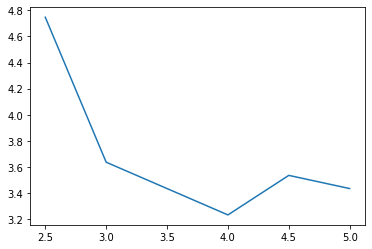

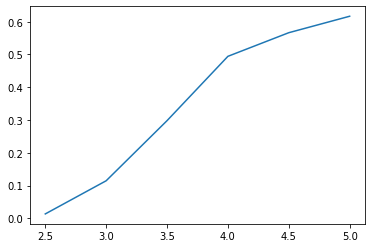

In [55]:
plt.plot(end, optimal)
plt.figure()
plt.plot(end, rate)

In [27]:
np.arange(2, 5, 0.5)

array([2. , 2.5, 3. , 3.5, 4. , 4.5])

In [32]:
def meme():
    print(f)
    
for i in range(3):
    f = 'food'
    meme()

food
food
food
